# No outliers data

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

## 5 fold

In [ ]:
normgendf = pd.read_csv("../RData/NoOutlier_filtered_normalized.csv")
metadata_df = pd.read_csv("../RData/metadata_randomGroup.csv")

In [56]:
merged_df = pd.merge(normgendf, metadata_df[['Group', 'mRNA']], on="mRNA")

In [57]:
merged_df['Group'].unique()

array([2, 6, 5, 3, 4, 1])


Processing fold for Group 1
Best C value: 0.03906939937054617
Inner 5-fold CV accuracy (average on training): 0.9416333523700743


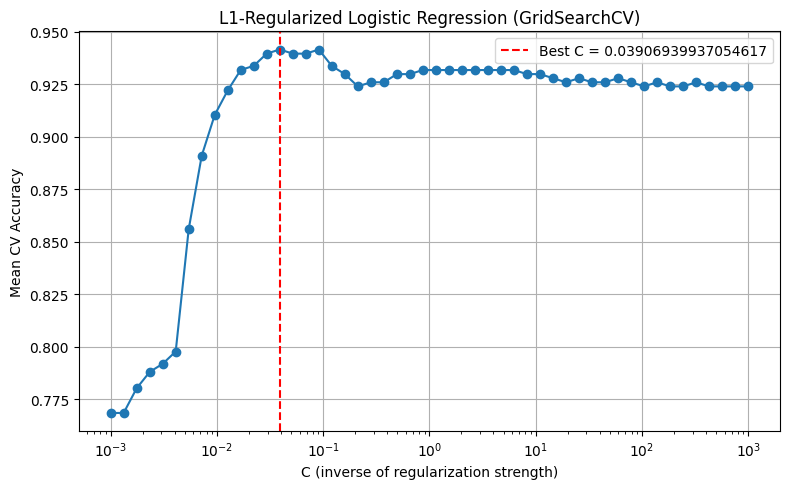

Number of selected genes in Group 1: 32
Test set accuracy: 0.9637681159420289
Confusion Matrix for Group 1:
[[ 28   3]
 [  2 105]]

Processing fold for Group 2
Best C value: 0.06866488450043001
Inner 5-fold CV accuracy (average on training): 0.9398342444013401


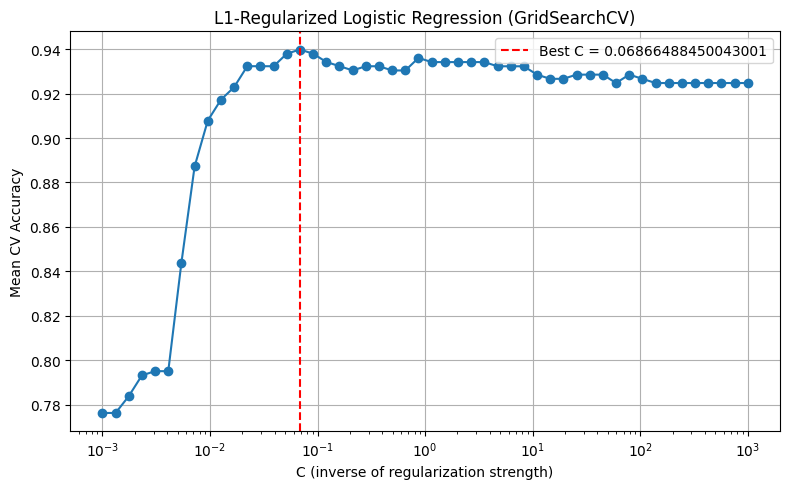

Number of selected genes in Group 2: 57
Test set accuracy: 0.975
Confusion Matrix for Group 2:
[[29  2]
 [ 1 88]]

Processing fold for Group 3
Best C value: 0.06866488450043001
Inner 5-fold CV accuracy (average on training): 0.9513992004568819


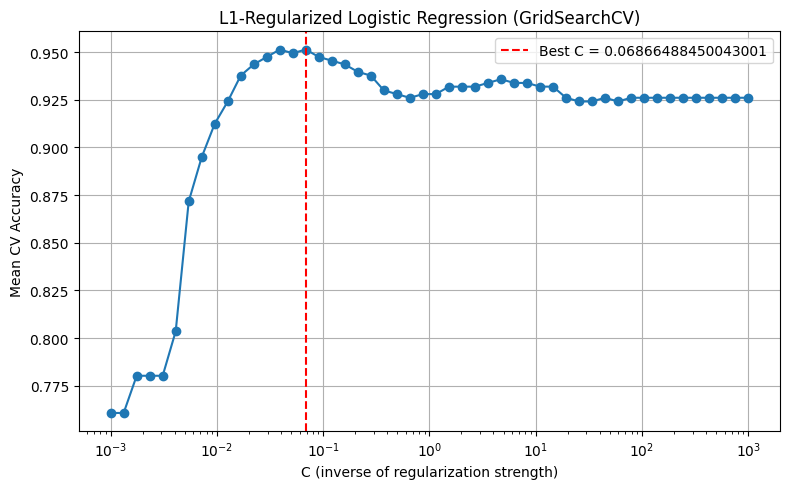

Number of selected genes in Group 3: 43
Test set accuracy: 0.9420289855072463
Confusion Matrix for Group 3:
[[ 22   5]
 [  3 108]]

Processing fold for Group 4
Best C value: 0.1206792640639329
Inner 5-fold CV accuracy (average on training): 0.9416143156291643


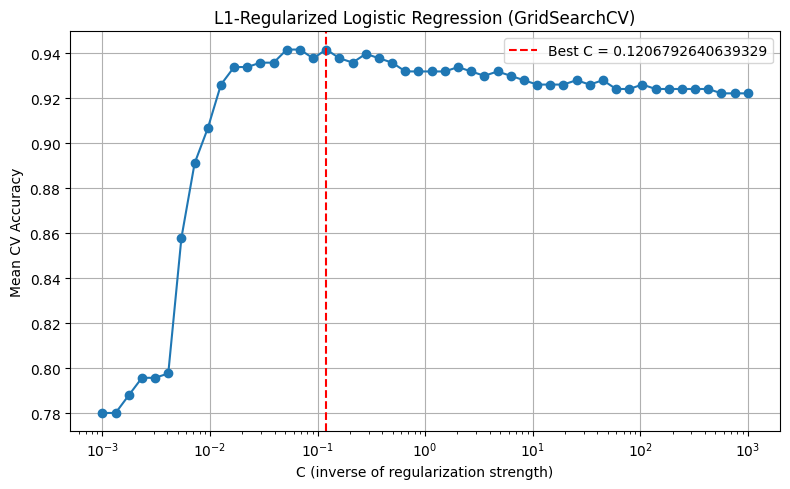

Number of selected genes in Group 4: 82
Test set accuracy: 0.9565217391304348
Confusion Matrix for Group 4:
[[33  4]
 [ 2 99]]

Processing fold for Group 5
Best C value: 0.1206792640639329
Inner 5-fold CV accuracy (average on training): 0.9568859107741139


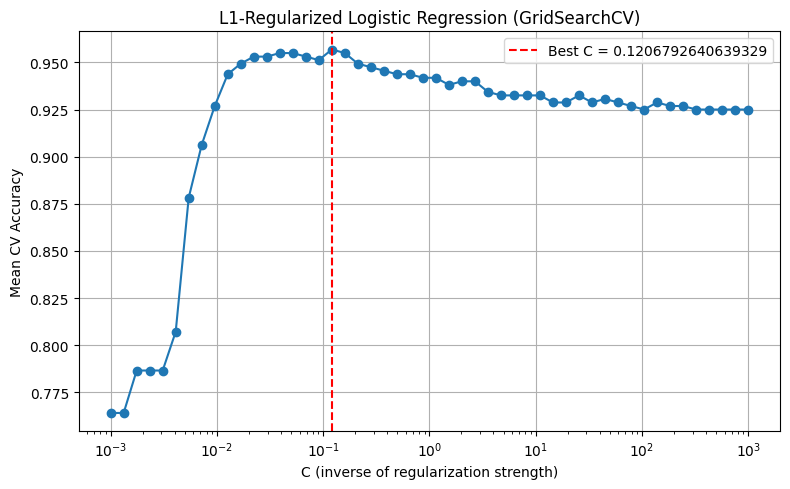

Number of selected genes in Group 5: 63
Test set accuracy: 0.923728813559322
Confusion Matrix for Group 5:
[[21  3]
 [ 6 88]]


In [58]:
from sklearn.linear_model import LassoCV

feature_cols = [col for col in merged_df.columns if col.startswith("ENSG")]
param_grid = {'C': np.logspace(-3, 3, 50)}  # 0.001, ..., 1000

groups = list(range(1, 6))  # Group 1 to Group 5
merged_df = merged_df[merged_df["Group"].isin(groups)].copy()
merged_df["ER"] = merged_df["ER"].astype(str)

# List to store outer test accuracies for each group fold
outer_test_accuracies = []
# Lists to store all true labels and predictions for an overall confusion matrix
all_true = []
all_pred = []

# Loop over each group as the test fold
for k in groups:
    print(f"\nProcessing fold for Group {k}")
    
    # Split data: test set = rows with current group k, training set = remaining rows
    train_df = merged_df[merged_df["Group"] != k].copy()
    test_df = merged_df[merged_df["Group"] == k].copy()
    
    # Use only the numeric gene expression features as predictors
    X_train = train_df[feature_cols]
    y_train = train_df["ER"]
    X_test = test_df[feature_cols]
    y_test = test_df["ER"]
    
    lasso_logistic = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
    # Set up GridSearchCV with 5-fold cross-validation on the training set
    grid_search = GridSearchCV(estimator=lasso_logistic, param_grid=param_grid, cv=5, scoring='accuracy')
    
    # Fit GridSearchCV on the training data
    grid_search.fit(X_train, y_train)

    best_C = grid_search.best_params_['C']
    best_cv_score = grid_search.best_score_
    print("Best C value:", best_C)
    print("Inner 5-fold CV accuracy (average on training):", best_cv_score)

    mean_test_scores = grid_search.cv_results_['mean_test_score']
    param_C_values = grid_search.cv_results_['param_C'].data  
    plt.figure(figsize=(8, 5))
    plt.plot(param_C_values, mean_test_scores, marker='o')
    plt.xscale('log')
    plt.xlabel('C (inverse of regularization strength)')
    plt.ylabel('Mean CV Accuracy')
    plt.title('L1-Regularized Logistic Regression (GridSearchCV)')
    plt.axvline(best_C, color='r', linestyle='--', label=f'Best C = {best_C}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    best_model = grid_search.best_estimator_
    coef = best_model.coef_.flatten()  # shape: (n_features,)

    # Get corresponding gene names
    nonzero_mask = coef != 0
    selected_genes = np.array(feature_cols)[nonzero_mask]
    selected_weights = coef[nonzero_mask]

    print(f"Number of selected genes in Group {k}: {len(selected_genes)}")
    #for gene, weight in zip(selected_genes, selected_weights):
    #    print(f"{gene}: {weight:.4f}")
    
    
    
    y_pred = grid_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test set accuracy:", test_accuracy)
    outer_test_accuracies.append(test_accuracy)
    
    all_true.extend(y_test.tolist())
    all_pred.extend(y_pred.tolist())
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for Group {k}:")
    print(cm)
    
    # Visualize the confusion matrix using matplotlib
    # plt.figure()
    # plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # plt.title(f'Confusion Matrix for Group {k}')
    # plt.colorbar()
    # tick_marks = np.arange(len(np.unique(merged_df["ER_y"])))
    # plt.xticks(tick_marks, np.unique(merged_df["ER_y"]))
    # plt.yticks(tick_marks, np.unique(merged_df["ER_y"]))
    # plt.xlabel('Predicted label')
    # plt.ylabel('True label')
    # plt.show()


## Overall performance metrics with conufion matrix 


Outer fold test accuracies: [0.9637681159420289, 0.975, 0.9420289855072463, 0.9565217391304348, 0.923728813559322]
Average outer test accuracy: 0.9522095308278062

Overall Confusion Matrix:
[[133  17]
 [ 14 488]]


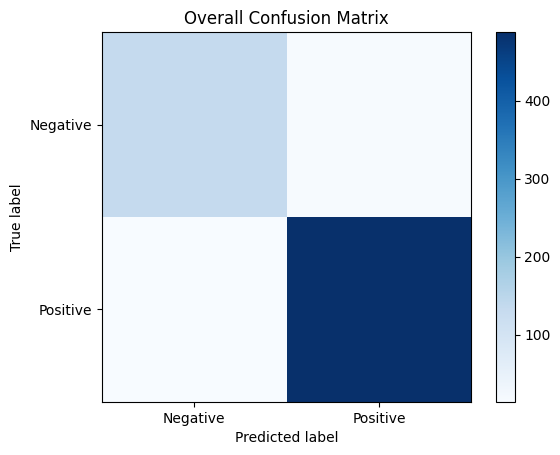

In [59]:
print("\nOuter fold test accuracies:", outer_test_accuracies)
print("Average outer test accuracy:", np.mean(outer_test_accuracies))

# Compute and display the overall confusion matrix across all folds
overall_cm = confusion_matrix(all_true, all_pred)
print("\nOverall Confusion Matrix:")
print(overall_cm)

# Visualize the overall confusion matrix using matplotlib
plt.figure()
plt.imshow(overall_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Overall Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(merged_df["ER"])))
plt.xticks(tick_marks, np.unique(merged_df["ER"]))
plt.yticks(tick_marks, np.unique(merged_df["ER"]))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# group 6 prediction

Best C value: 0.0517947467923121
Inner 5-fold CV accuracy (average on training): 0.9493716970052848


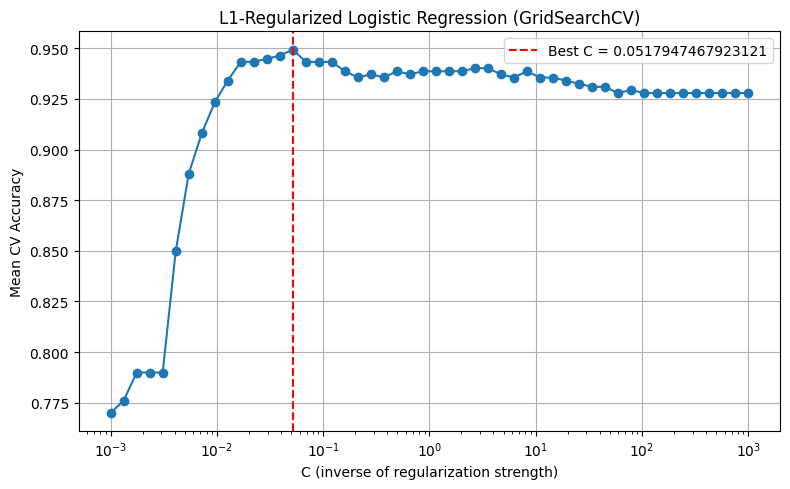

In [67]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
merged_df = pd.merge(normgendf, metadata_df[['Group', 'mRNA']], on="mRNA")
train_df = merged_df[merged_df["Group"].isin([1, 2, 3, 4, 5])].copy()
X_train = train_df[feature_cols]
y_train = train_df["ER"]

# For testing, we want group 6 rows even if ER_y is missing (to predict them)
test_df = merged_df[merged_df["Group"] == 6].copy()

# Convert the target variable to string for training
train_df["ER"] = train_df["ER"].astype(str)

# Select only the numeric gene expression features (columns starting with "ENSG")
feature_cols = [col for col in merged_df.columns if col.startswith("ENSG")]

# Set up a grid of C values for logistic regression (L1 penalty)
param_grid = {'C': np.logspace(-3, 3, 50)}  # 0.001, 0.01, 0.1, 1, 10, 100, 1000

# Initialize logistic regression with L1 penalty (LASSO)
lasso_logistic = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Set up GridSearchCV with 5-fold cross-validation on the training set
grid_search = GridSearchCV(estimator=lasso_logistic, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model using the training data (only rows with non-missing ER_y)
X_train = train_df[feature_cols]
y_train = train_df["ER"]
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']
best_cv_score = grid_search.best_score_
print("Best C value:", best_C)
print("Inner 5-fold CV accuracy (average on training):", best_cv_score)

mean_test_scores = grid_search.cv_results_['mean_test_score']
param_C_values = grid_search.cv_results_['param_C'].data  
plt.figure(figsize=(8, 5))
plt.plot(param_C_values, mean_test_scores, marker='o')
plt.xscale('log')
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('Mean CV Accuracy')
plt.title('L1-Regularized Logistic Regression (GridSearchCV)')
plt.axvline(best_C, color='r', linestyle='--', label=f'Best C = {best_C}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
best_model = grid_search.best_estimator_
coef = best_model.coef_.flatten()  # shape: (n_features,)
# Get corresponding gene names
nonzero_mask = coef != 0
selected_genes = np.array(feature_cols)[nonzero_mask]
selected_weights = coef[nonzero_mask]

print(f"Number of selected genes in Group {k}: {len(selected_genes)}")
for gene, weight in zip(selected_genes, selected_weights):
    print(f"{gene}: {weight:.4f}")
selected_genes

Number of selected genes in Group 5: 45
ENSG00000173467: 0.1849
ENSG00000151892: 0.0038
ENSG00000091831: 0.2565
ENSG00000204385: 0.0080
ENSG00000134258: -0.0252
ENSG00000175356: 0.0666
ENSG00000104332: -0.0295
ENSG00000003989: 0.0089
ENSG00000171428: 0.0103
ENSG00000132465: -0.0138
ENSG00000115221: -0.0039
ENSG00000158258: 0.0091
ENSG00000135480: -0.0472
ENSG00000159166: -0.0497
ENSG00000074410: 0.0684
ENSG00000168350: 0.0697
ENSG00000166106: 0.0079
ENSG00000196208: 0.0905
ENSG00000058085: -0.0001
ENSG00000135218: 0.0167
ENSG00000125740: 0.0131
ENSG00000111341: -0.0389
ENSG00000062038: -0.0513
ENSG00000146648: -0.0462
ENSG00000117115: -0.0249
ENSG00000134755: -0.0138
ENSG00000103257: -0.0179
ENSG00000254726: -0.0527
ENSG00000166927: 0.0184
ENSG00000121039: -0.0146
ENSG00000117399: -0.0048
ENSG00000137563: -0.0091
ENSG00000135916: -0.0157
ENSG00000094804: -0.0155
ENSG00000111206: -0.0270
ENSG00000083857: -0.0325
ENSG00000091490: -0.0827
ENSG00000104341: -0.0001
ENSG00000029993: -0.0062


array(['ENSG00000173467', 'ENSG00000151892', 'ENSG00000091831',
       'ENSG00000204385', 'ENSG00000134258', 'ENSG00000175356',
       'ENSG00000104332', 'ENSG00000003989', 'ENSG00000171428',
       'ENSG00000132465', 'ENSG00000115221', 'ENSG00000158258',
       'ENSG00000135480', 'ENSG00000159166', 'ENSG00000074410',
       'ENSG00000168350', 'ENSG00000166106', 'ENSG00000196208',
       'ENSG00000058085', 'ENSG00000135218', 'ENSG00000125740',
       'ENSG00000111341', 'ENSG00000062038', 'ENSG00000146648',
       'ENSG00000117115', 'ENSG00000134755', 'ENSG00000103257',
       'ENSG00000254726', 'ENSG00000166927', 'ENSG00000121039',
       'ENSG00000117399', 'ENSG00000137563', 'ENSG00000135916',
       'ENSG00000094804', 'ENSG00000111206', 'ENSG00000083857',
       'ENSG00000091490', 'ENSG00000104341', 'ENSG00000029993',
       'ENSG00000146072', 'ENSG00000139146', 'ENSG00000136193',
       'ENSG00000152894', 'ENSG00000108344', 'ENSG00000106392'],
      dtype='<U15')

In [87]:
X_test = test_df[feature_cols]
predictions = grid_search.predict(X_test)
test_predicted = test_df[['mRNA']].copy()
test_predicted['ER_lasso'] = predictions

In [89]:
test_predicted

,mRNA,ER_lasso
1,TCGA-BH-A0HQ-01A-11R-A034-07,Positive
5,TCGA-A1-A0SD-01A-11R-A115-07,Positive
24,TCGA-A2-A0CQ-01A-21R-A034-07,Positive
25,TCGA-A2-A0CS-01A-11R-A115-07,Positive
49,TCGA-A2-A0YC-01A-11R-A109-07,Positive
...,...,...
723,TCGA-D8-A1XC-01A-11R-A14D-07,Positive
728,TCGA-E2-A14T-01A-11R-A115-07,Positive
738,TCGA-E2-A1LG-01A-21R-A14M-07,Negative
740,TCGA-E9-A54X-01A-11R-A266-07,Positive


In [94]:
import numpy as np#metadf['Group'] = metadf['ER'].apply(lambda x: 6 if pd.isna(x) else np.random.randint(1, 6))
csv_filename = "../RData/predicted_lasso.csv"
test_predicted.to_csv(csv_filename, index=False)

In [93]:
test_predicted

,mRNA,ER_lasso
1,TCGA-BH-A0HQ-01A-11R-A034-07,Positive
5,TCGA-A1-A0SD-01A-11R-A115-07,Positive
24,TCGA-A2-A0CQ-01A-21R-A034-07,Positive
25,TCGA-A2-A0CS-01A-11R-A115-07,Positive
49,TCGA-A2-A0YC-01A-11R-A109-07,Positive
...,...,...
723,TCGA-D8-A1XC-01A-11R-A14D-07,Positive
728,TCGA-E2-A14T-01A-11R-A115-07,Positive
738,TCGA-E2-A1LG-01A-21R-A14M-07,Negative
740,TCGA-E9-A54X-01A-11R-A266-07,Positive
